In [1]:
# !pip install 'git+https://github.com/zhanghang1989/detectron2-ResNeSt.git'

In [17]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import sys
# import some common libraries
import numpy as np
import cv2
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [ ]:
path2csv = 'train.csv'
path2pth = 'pretrain.pth'
MAX_ITER = '90000'
epoch_ = "0"
path2save = "output_".format(epoch_)

In [3]:
import pandas as pd
df_train = pd.read_csv(path2csv)
df_val = pd.read_csv("../data/val.csv")

In [4]:
df_train.tail()

image_id  height  width   x0   y0    w    h
3149167     26979    1024   1024  695  979  124   45
3149168     26979    1024   1024   86  915  139  109
3149169     26979    1024   1024  964  922   36   84
3149170     26979    1024   1024  995  931   29   93
3149171     26979    1024   1024  982  635   42   69

In [5]:
df_train.shape

(3149172, 7)

In [6]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
from tqdm import tqdm_notebook
def get_data_dicts(df,source):
    dataset_dicts = []
    for idx, [index,row] in tqdm_notebook(enumerate(df.groupby('image_id'))):
        record = {}
        row = row.reset_index()
        filename = os.path.join("../data/{}/".format(source), str(row["image_id"].iloc[0])+".jpg")
        height, width = 1024,1024
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = row[["x0","y0","w","h"]].values.astype(float)
        c = row.values[:,-5]
        objs = []
        for c1,[xmin, ymin, width2, height2] in zip(c,annos):
            cc = int(0)
            px =[xmin,xmin+width2,xmin+width2,xmin]
            py = [ymin,ymin,ymin+height2,ymin+height2]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            obj = {
                "bbox": [int(xmin),int(ymin),int(xmin)+int(width2),int(ymin)+int(height2)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog



In [7]:
for dff,d in zip([df_val],["val"]):
    print(d)
    print(len(dff))
    DatasetCatalog.register("orW52_" + d, lambda d=d: get_data_dicts(dff,source=d))
    MetadataCatalog.get("orW52_" + d).set(thing_classes=['wheat'])
    print("orW52_" + d)

val
29592
orW52_val


In [8]:
for dff,d in zip([df_train],["train"]):
    print(d)
    print(len(dff))
    DatasetCatalog.register("train_aug410_" + d, lambda d=d: get_data_dicts(dff,source=d))
    MetadataCatalog.get("train_aug410_" + d).set(thing_classes=['wheat'])
    print("train_aug410_" + d)
metadata = MetadataCatalog.get("train_aug410_train")

train
1000
train_aug410_train


In [9]:
len(df_train)

3149172

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


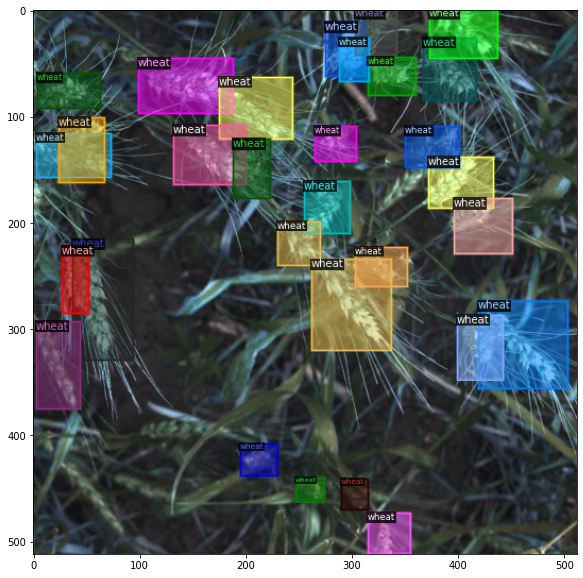

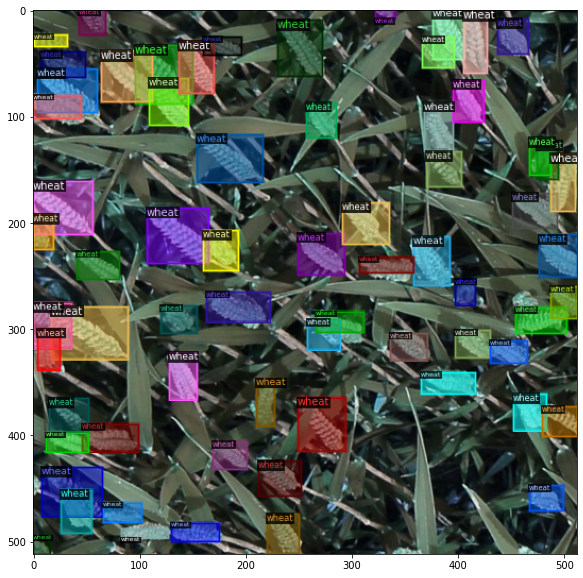

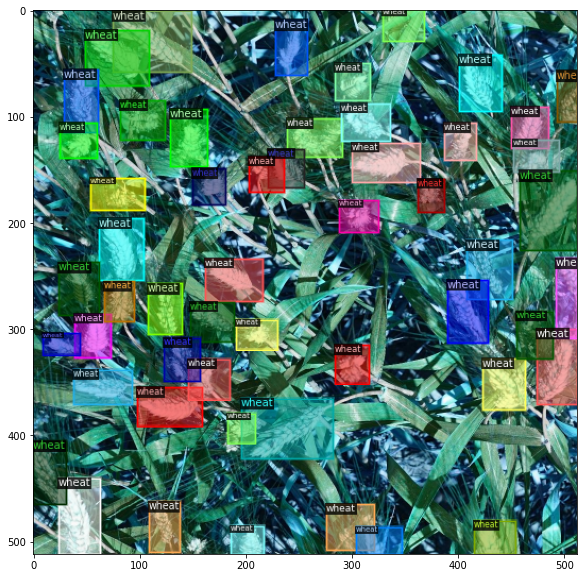

675


In [10]:
from matplotlib import pyplot as plt
dataset_dicts = get_data_dicts(df_val,source="val")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=[10,10])
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()
print(len(dataset_dicts))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


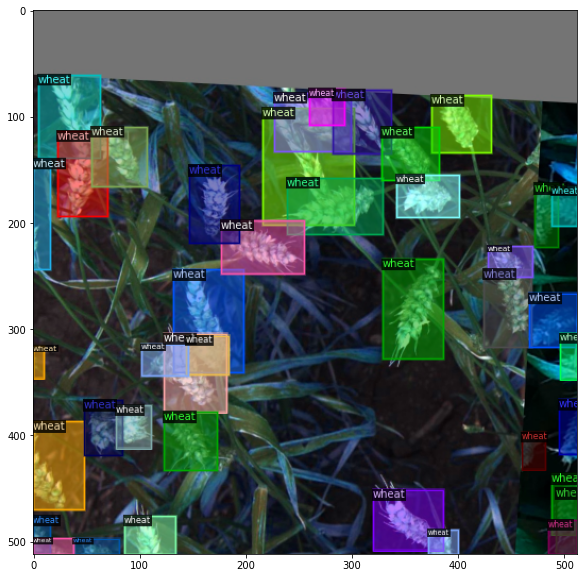

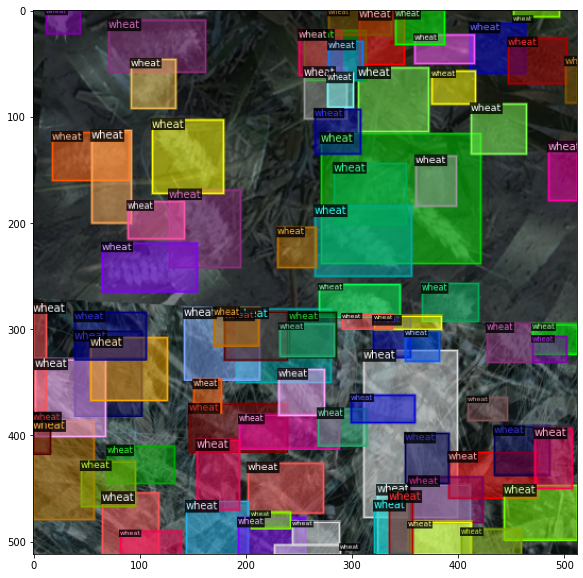

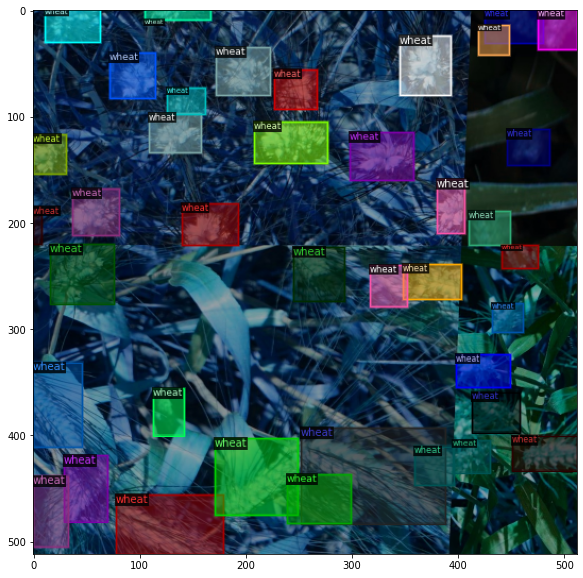

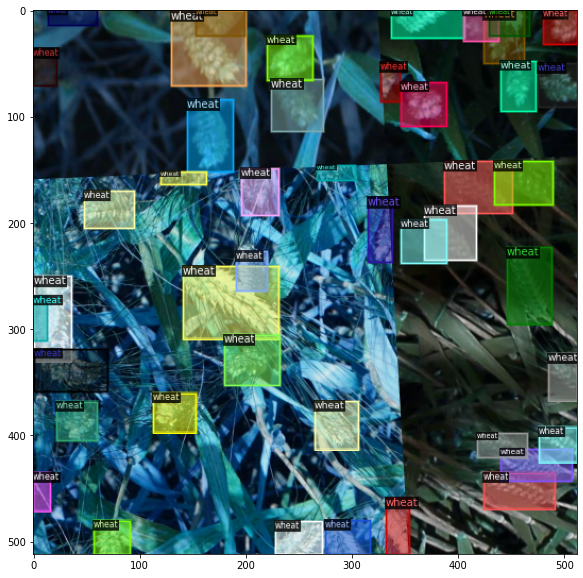

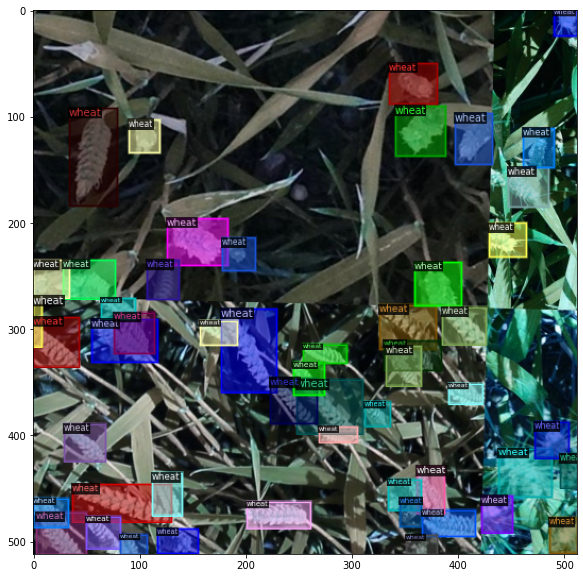

71


In [11]:
from matplotlib import pyplot as plt
dataset_dicts = get_data_dicts(df_train[1000:5000],source="train")
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=[10,10])
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()
print(len(dataset_dicts))

In [12]:
!wget https://s3.us-west-1.wasabisys.com/resnest/detectron/faster_cascade_rcnn_ResNeSt_101_FPN_syncbn_range-scale_1x-3627ef78.pth

In [13]:
# !wget https://s3.us-west-1.wasabisys.com/resnest/detectron/faster_cascade_rcnn_ResNeSt_50_FPN_syncbn_range-scale-1x-e9955232.pth

--2020-07-10 14:47:31--  https://s3.us-west-1.wasabisys.com/resnest/detectron/faster_cascade_rcnn_ResNeSt_50_FPN_syncbn_range-scale-1x-e9955232.pth
Resolving s3.us-west-1.wasabisys.com (s3.us-west-1.wasabisys.com)... 76.191.80.13, 76.191.80.12, 76.191.80.10, ...
Connecting to s3.us-west-1.wasabisys.com (s3.us-west-1.wasabisys.com)|76.191.80.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 601517776 (574M) [binary/octet-stream]
Saving to: ‘faster_cascade_rcnn_ResNeSt_50_FPN_syncbn_range-scale-1x-e9955232.pth.1’

faster_cascade_rcnn 100%[===================>] 573.65M  40.2MB/s    in 15s     

2020-07-10 14:47:47 (38.0 MB/s) - ‘faster_cascade_rcnn_ResNeSt_50_FPN_syncbn_range-scale-1x-e9955232.pth.1’ saved [601517776/601517776]



In [14]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_cascade_rcnn_ResNeSt_50_FPN_syncbn_range-scale-1x.yaml"))
cfg.DATASETS.TRAIN = ("train_aug410_train",)
cfg.DATASETS.TEST = ("orW52_val",)
cfg.DATALOADER.NUM_WORKERS = 5
#
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_cascade_rcnn_ResNeSt_50_FPN_syncbn_range-scale-1x.yaml")  # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = path2pth
cfg.SOLVER.IMS_PER_BATCH = 5
# cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = MAX_ITER
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 
cfg.TEST.EVAL_PERIOD = 5000
cfg.OUTPUT_DIR = "output2"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
class CocoTrainer(DefaultTrainer):
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"
    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [15]:
trainer = DefaultTrainer(cfg) 

[07/10 14:47:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(
      256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): NaiveSyncBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fpn_output2): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): NaiveSyncBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fpn_lateral3): Conv2d(
      512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): NaiveSyncBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fpn_output3): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): NaiveSyncBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fpn_lateral4): Conv2d(
      1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



[07/10 14:47:51 d2.data.build]: Removed 0 images with no usable annotations. 14 images left.
[07/10 14:47:51 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   wheat    | 1000         |
|            |              |
[07/10 14:47:51 d2.data.common]: Serializing 14 elements to byte tensors and concatenating them all ...
[07/10 14:47:51 d2.data.common]: Serialized dataset takes 0.19 MiB
[07/10 14:47:51 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 800), max_size=1333, sample_style='range'), RandomFlip()]
[07/10 14:47:51 d2.data.build]: Using training sampler TrainingSampler



[07/10 14:47:51 d2.data.build]: Removed 0 images with no usable annotations. 14 images left.
[07/10 14:47:51 d2.data.common]: Serializing 14 elements to byte tensors and concatenating them all ...
[07/10 14:47:51 d2.data.common]: Serialized dataset takes 0.19 MiB
[07/10 14:47:51 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 800), max_size=1333, sample_style='range'), RandomFlip()]
[07/10 14:47:51 d2.data.build]: Using training sampler TrainingSampler


In [16]:
trainer.resume_or_load(resume=True)
trainer.train()

'roi_heads.box_predictor.0.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.0.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.1.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.1.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.2.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.2.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.


[07/10 14:47:53 d2.engine.train_loop]: Starting training from iteration 90000
[07/10 14:48:21 d2.utils.events]:  eta: 3:48:24  iter: 90019  total_loss: 7.933  loss_cls_stage0: 0.643  loss_box_reg_stage0: 0.629  loss_cls_stage1: 0.655  loss_box_reg_stage1: 0.850  loss_cls_stage2: 0.600  loss_box_reg_stage2: 0.603  loss_rpn_cls: 3.629  loss_rpn_loc: 0.376  time: 1.3546  data_time: 0.0365  lr: 0.000400  max_mem: 12095M
[07/10 14:48:35 d2.engine.hooks]: Running precise-BN for 200 iterations...  Note that this could produce different statistics every time.
[07/10 14:49:54 d2.engine.hooks]: Running precise-BN ... 100/200 iterations.
[07/10 14:51:16 d2.engine.hooks]: Running precise-BN ... 200/200 iterations.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



[07/10 14:51:17 d2.data.common]: Serializing 14 elements to byte tensors and concatenating them all ...
[07/10 14:51:17 d2.data.common]: Serialized dataset takes 0.19 MiB
WARNING [07/10 14:51:17 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'orW52_val'. Trying to convert it to COCO format ...
[07/10 14:51:17 d2.data.datasets.coco]: Converting annotations of dataset 'orW52_val' to COCO format ...)



[07/10 14:51:17 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[07/10 14:51:18 d2.data.datasets.coco]: Conversion finished, num images: 14, num annotations: 1000
[07/10 14:51:18 d2.data.datasets.coco]: Caching COCO format annotations at 'coco_eval/orW52_val_coco_format.json' ...
[07/10 14:51:18 d2.evaluation.evaluator]: Start inference on 14 images
ERROR [07/10 14:51:18 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/detectron2/engine/train_loop.py", line 133, in train
    self.after_step()
  File "/opt/conda/lib/python3.7/site-packages/detectron2/engine/train_loop.py", line 154, in after_step
    h.after_step()
  File "/opt/conda/lib/python3.7/site-packages/detectron2/engine/hooks.py", line 350, in after_step
    self._do_eval()
  File "/opt/conda/lib/python3.7/site-packages/detectron2/engine/hooks.py", line 324, in _do_eval
    results = self._func()
  File "/opt/conda/lib/python3.

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.7/site-packages/detectron2/data/common.py", line 41, in __getitem__
    data = self._map_func(self._dataset[cur_idx])
  File "/opt/conda/lib/python3.7/site-packages/detectron2/utils/serialize.py", line 23, in __call__
    return self._obj(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/detectron2/data/dataset_mapper.py", line 77, in __call__
    image = utils.read_image(dataset_dict["file_name"], format=self.img_format)
  File "/opt/conda/lib/python3.7/site-packages/detectron2/data/detection_utils.py", line 48, in read_image
    with PathManager.open(file_name, "rb") as f:
  File "/opt/conda/lib/python3.7/site-packages/fvcore/common/file_io.py", line 574, in open
    path, mode, buffering=buffering, **kwargs
  File "/opt/conda/lib/python3.7/site-packages/fvcore/common/file_io.py", line 379, in _open
    opener=opener,
FileNotFoundError: [Errno 2] No such file or directory: '../data/val2/43168.jpg'


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import os


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
# from matplotlib import pyplot as plt
from utils import *

In [ ]:
from ensemble_boxes import *
def run_wbf(boxes, scores, image_size=1023, iou_thr=0.5, skip_box_thr=0.7, weights=None):
    #boxes = [prediction[image_index]['boxes'].data.cpu().numpy()/(image_size-1) for prediction in predictions]
    #scores = [prediction[image_index]['scores'].data.cpu().numpy() for prediction in predictions]
    labels = [np.zeros(score.shape[0]) for score in scores]
    boxes = [box/(image_size) for box in boxes]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    #boxes, scores, labels = nms(boxes, scores, labels, weights=[1,1,1,1,1], iou_thr=0.5)
    boxes = boxes*(image_size)
    return boxes, scores, labels

In [ ]:
def TTAImage(image, index):
    image1 = image.copy()
    if index==0: 
        rotated_image = cv2.rotate(image1, cv2.ROTATE_90_CLOCKWISE)
        return rotated_image
    elif index==1:
        rotated_image2 = cv2.rotate(image1, cv2.ROTATE_90_CLOCKWISE)
        rotated_image2 = cv2.rotate(rotated_image2, cv2.ROTATE_90_CLOCKWISE)
        return rotated_image2
    elif index==2:
        rotated_image3 = cv2.rotate(image1, cv2.ROTATE_90_CLOCKWISE)
        rotated_image3 = cv2.rotate(rotated_image3, cv2.ROTATE_90_CLOCKWISE)
        rotated_image3 = cv2.rotate(rotated_image3, cv2.ROTATE_90_CLOCKWISE)
        return rotated_image3
    elif index == 3:
        return image1

In [ ]:
def rotBoxes90(boxes, im_w, im_h):
    ret_boxes =[]
    for box in boxes:
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = x1-im_w//2, im_h//2 - y1, x2-im_w//2, im_h//2 - y2
        x1, y1, x2, y2 = y1, -x1, y2, -x2
        x1, y1, x2, y2 = int(x1+im_w//2), int(im_h//2 - y1), int(x2+im_w//2), int(im_h//2 - y2)
        x1a, y1a, x2a, y2a = min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2)
        ret_boxes.append([x1a, y1a, x2a, y2a])
    return np.array(ret_boxes)

In [ ]:
from detectron2.config import get_cfg
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_cascade_rcnn_ResNeSt_101_FPN_syncbn_range-scale_1x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 


cfg.MODEL.WEIGHTS = os.path.join('./output/', "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4 # set the testing threshold for this model
# cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.45
cfg.DATASETS.TEST = ("m5_val", )
predictor1 = DefaultPredictor(cfg)

In [ ]:
import pandas as pd
df_val = pd.read_csv("../data/val_aug.csv")

In [ ]:
iou_thresholds = []
for x in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    iou_thresholds.append(x)

In [ ]:
def calculate_image_precision(gts, preds, thresholds = iou_thresholds, form = 'pascal_voc'):
    n_threshold = 6
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1


    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

In [ ]:
def predictImg(img):
    outputs = predictor1(im)
    out = outputs["instances"].to("cpu")
    scores = out.get_fields()['scores'].numpy()
    boxes = out.get_fields()['pred_boxes'].tensor.numpy().astype(int)
    labels= out.get_fields()['scores'].numpy()
    return boxes,scores

In [ ]:
def flipCord(bbox):
    bb = np.zeros_like(bbox)
    bb[:,0] = 1023-bbox[:,2]
    bb[:,2] = 1023-bbox[:,0]
    bb[:,1] = bbox[:,1]
    bb[:,3] = bbox[:,3]
    return bb

In [ ]:
import cv2
import glob
from tqdm import tqdm
results = []
for image_id in tqdm(list(set(df_val['image_id']))):
    gt = df_val[df_val.image_id == image_id].values[:,3:]
    im = cv2.imread('../data/val2/{}.jpg'.format(image_id))
    im_w, im_h = im.shape[:2]
    boxes,scores = predictImg(im)   
    boxes = boxes[scores >= 0.1].astype(np.int32)
    scores = scores[scores >=float(0.1)]
    results.append({"image_id":image_id,"bboxs":boxes,"scores":scores,"gt":gt})

In [ ]:
final_scores = []
for row in tqdm(range(len(results))):
    gt_boxes = results[row]['gt'].copy()
    gt_boxes[:,2] = gt_boxes[:,0] + gt_boxes[:,2]  
    gt_boxes[:,3] = gt_boxes[:,1] + gt_boxes[:,3]  
    boxes = results[row]['bboxs'] 
    image_precision = calculate_image_precision(gt_boxes, boxes)
    final_scores.append(image_precision)
print(np.mean(final_scores))
np.svae("epoch_{}_".foramt(epoch_,np.mean(final_scores)),np.mean(final_scores))